In [31]:
# UT-TOR-DATA-PT-01-2020-U-C Week 11
# Web Design Challenge
# Creates a stack chart showing results of all the parties on all the elections
# (c) Boris Smirnov

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import utilities as u

In [33]:
years_lst = [2004, 2006, 2008, 2011, 2015, 2019]
party_lst = ['LIB', 'CPC', 'NDP', 'BQ', 'GRN']

# Elections that we can compare riding-by-riding
# First group, 2004-2011, corresponds to 2003 representation order (308 ridings)
# Second group, 2015-2019, coresponds to 2013 representation order (338 ridings)
# We cannot compare ridings between 2011 and 2015 elections, because the are from differens ROs
compare_lst = [ (2006, 2004), (2008, 2006), (2011, 2008), (2019, 2015) ]

# I have custom names only for the parties in the list. Very convenient
p_df = u.parties_df[['Id', 'Custom Name']].dropna()
party_names = dict(zip(p_df['Id'], p_df['Custom Name']))

# Extending parties with "Other" - there were some independent candidates, who made into the parliament
party_lst += ['OTH']
party_names['OTH'] = 'Independent'

party_colors = {
    'LIB': '#EA6D6A', # red
    'CPC': "#6495ED", # blue
    'NDP': "#F4A460", # orange
    'BQ' : "#87CEFA", # light blue
    'GRN': "#99C955", # green
    'OTH': "#A9A9A9"  # gray
}

# Custom name for chart titles
title_names = {
    'LIB': "the Liberal Party",
    'CPC': "the Conservative Party",
    'NDP': "the New Democratic Party",
    'BQ' : "the Bloc Québécois",
    'GRN': "the Green Party",
    'OTH': "other candidates"
}

In [34]:
# The function returns a dataframe with FEDs where winning party is different from previous year
# Input: an elections year and previous elections year for comparison
# Resulting DataFrame: index='FED Id', columns=['This year', 'Past year'] - contain party ids
def prepare_dataset(this_year, past_year):
    # Load files
    this_year_df = pd.read_csv(f"data{this_year}.csv")
    past_year_df = pd.read_csv(f"data{past_year}.csv")
    
    # Drop unnecessary columns - leave only 'FED Id' and 'Winning Pid'
    drop_columns = ['Province Id', 'Province Name', 'FED Name', 'Ballots', 'Candidate Pid', 'Votes']
    this_year_df.drop(columns=drop_columns, inplace=True)
    past_year_df.drop(columns=drop_columns, inplace=True)

    # Remove duplicates
    this_year_s = this_year_df.groupby('FED Id')['Winning Pid'].first()
    past_year_s = past_year_df.groupby('FED Id')['Winning Pid'].first()

    # Rename
    this_year_s.name = 'This year'
    past_year_s.name = 'Past year'
    
    # Merge into resulting dataset, remove unchanged election results, rename IND and NOA to OTH
    gains_losses_df = pd.merge(this_year_s, past_year_s, left_index=True, right_index=True)
    gains_losses_df = gains_losses_df[gains_losses_df['This year'] != gains_losses_df['Past year']]
    gains_losses_df = gains_losses_df.applymap(lambda p: 'OTH' if p in ['IND', 'NOA'] else p)
    
    return gains_losses_df

In [35]:
# The function returns stats for a given party: how many seats were lost/gained to/from rival parties
# Input: party name and DataFrame with complete comparison data (from the function above)
# Output DataFrame:
#     index - party ids,
#     columns=['Gained from', 'Lost to'] - positive values are gains, negative - losses
def party_gains_losses(party, gains_losses_df):
    # Calculate gains and losses for a given party
    gains_df = gains_losses_df[gains_losses_df['This year'] == party].groupby('Past year').count()
    losses_df = gains_losses_df[gains_losses_df['Past year'] == party].groupby('This year').count()

    combined_df = pd.merge(
        gains_df, losses_df.applymap(lambda n: -n),
        how='outer', left_index=True, right_index = True)\

    combined_df.fillna(value=0, inplace=True)
    combined_df = combined_df.astype(int)
    combined_df.columns = ['Gained from', 'Lost to']
    combined_df['Spread'] = combined_df['Gained from'] - combined_df['Lost to']
    combined_df.sort_values(['Spread'], ascending=False, inplace=True)

    return combined_df

In [36]:
# The function generates 'gains and losses' chart for a given party for given years
# Input: party id, compared years, gails and losses dataframe (from the function above)
# Output: chart
def plot_chart(party, this_year, past_year, combined_df):
    global party_lst, party_names, party_colors, title_names
    # Bar labeling test (used with test dataset passed as a parameter)
    #val = 1
    #combined_df.iloc[0] = { 'Gained from': val, 'Lost to': -val, 'Spread': val * 2 }
    
    absolute_max = max(-combined_df['Lost to'].min(), combined_df['Gained from'].max())

    # Draw a chart
    fig = plt.figure(figsize=(7.5, 5))
    axes = plt.subplot()

    # Titles, labels, annotations
    axes.set_title(
        f"Seat gains and losses of {title_names[party]}\n(comparing {this_year} and {past_year} elections)",
        fontdict={'fontsize': 14})
    #axes.set_xlabel('Number of seats lost (negative) and gained (positive)', fontdict={'fontsize': 12})
    axes.set_xlabel(' ', fontdict={'fontsize': 12}) # place holder for carousel indicators
    plt.annotate(
        'Number of seats lost to...', #'Lost to',
        xy=(0, len(party_lst)),
        xytext=(-absolute_max / 2, len(party_lst) - 0.5),
        ha='center', va='center', color='black', fontsize=12
    )
    plt.annotate(
        'Number of seats gained from...', #'Gained from',
        xy=(0, len(party_lst)),
        xytext=(absolute_max / 2, len(party_lst) - 0.5),
        ha='center', va='center', color='black', fontsize=12
    )

    # Drawing the bars
    bars = plt.barh(
        [0.5 + i for i in range(len(combined_df))], # y axis
         combined_df['Spread'], # width
         left=combined_df['Lost to'], # left side
         height=0.8, align='center',
         color=[party_colors[p] for p in combined_df.index]
    )

    # X-axis
    axes.set_xlim(left=-absolute_max, right=absolute_max)
    plt.axvline(0, color='black', linewidth=1) # Central vertical axis - 0
    axes.set_xticks([]) # Too messy. I'll label the bars with annotations

    # Y-axis
    max_y = len(party_lst)
    axes.set_ylim(bottom=0, top=max_y)
    axes.set_yticks([]) # Y-axis is parties. I'll put them into a legend

    # Labels inside the bars
    # https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
    threshold = 1.0 / 9.0 # If a bar is too narrow, print label outside it
    for i, bar in enumerate(bars):
        (left_x, y) = bar.get_xy()
        right_x = left_x + bar.get_width()
        height = bar.get_height()
        loss = combined_df.iloc[i, 1]
        gain = combined_df.iloc[i, 0]

        if gain:
            if float(gain) / absolute_max < threshold:
                mirror = -1  # if the bar is too narrow, put the label outside
                ha = 'left'
            else:
                mirror = 1 # If bar width is ok, then put the label inside
                ha = 'right'

            axes.annotate(str(gain),
                xy=(right_x, y + height / 2), # the point to annotate
                xytext=(-6 * mirror, 0),  # horizontal offset
                textcoords="offset points",
                ha=ha, va='center', color='black', fontsize=12)

        if loss:
            if float(-loss) / absolute_max < threshold:
                mirror = -1  # if the bar is too narrow, put the label outside
                ha = 'right'
            else:
                mirror = 1 # If bar with is ok, then put the label inside
                ha = 'left'

            axes.annotate(str(loss),
                xy=(left_x, y + height / 2), # the point to annotate
                xytext=(6 * mirror, 0),  # horizontal offset
                textcoords="offset points",
                ha=ha, va='center', color='black', fontsize=12)

    # Making a legend
    # https://matplotlib.org/3.1.1/tutorials/intermediate/legend_guide.html
    legend_handles = [mpatches.Patch(color=party_colors[p], label=party_names[p]) for p in combined_df.index]
    plt.legend(
        handles=legend_handles, loc='upper right',
        bbox_to_anchor=(1.0, (max_y - 1.0) / max_y, 0.0, 0.0)) # Top "line" of the chart is for annotations

    plt.savefig(f"../images/gains_{party}_{this_year}_barh.svg", bbox_inches = 'tight')
    plt.show()


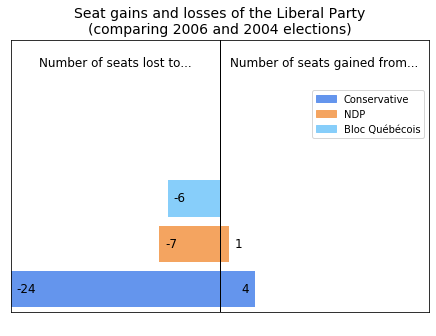

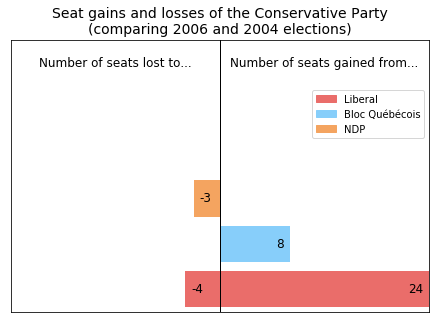

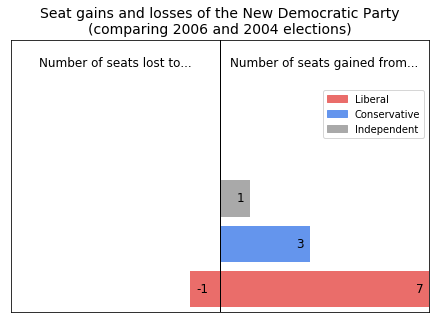

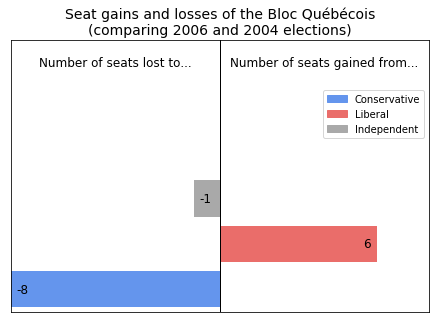

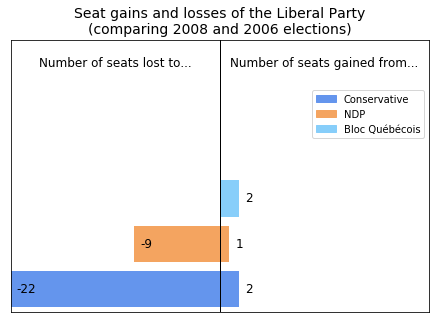

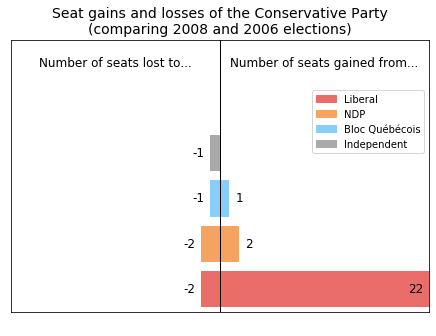

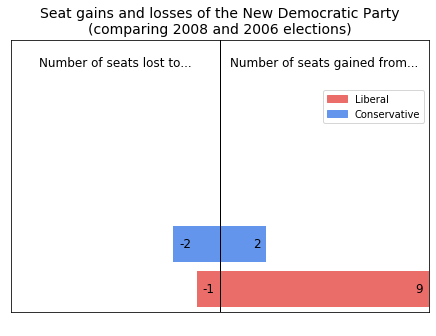

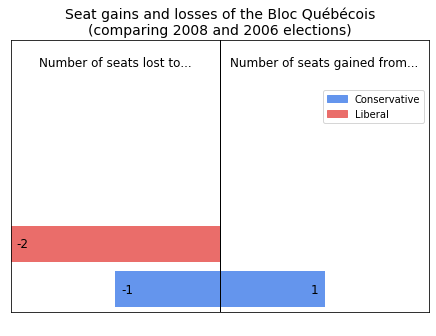

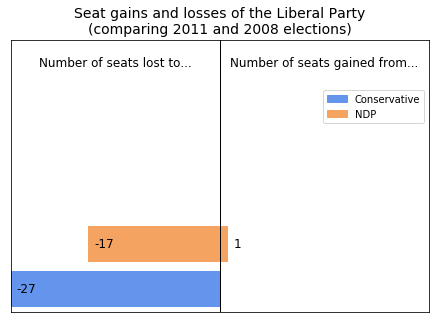

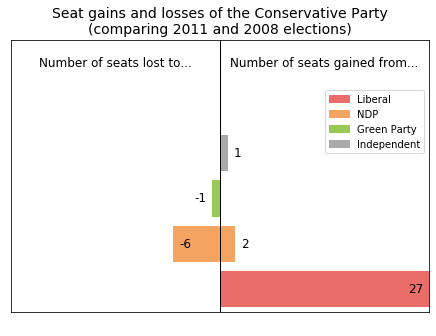

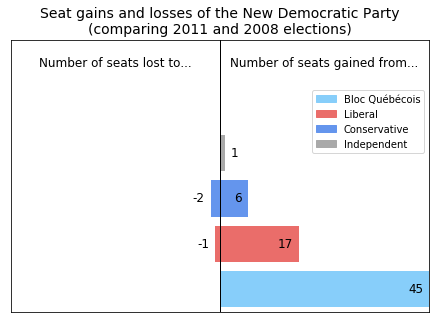

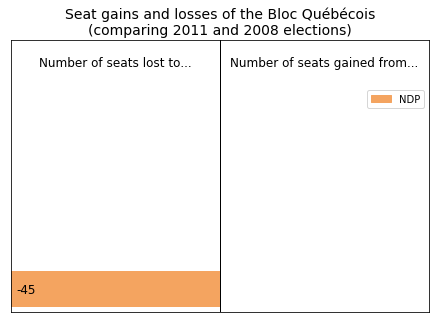

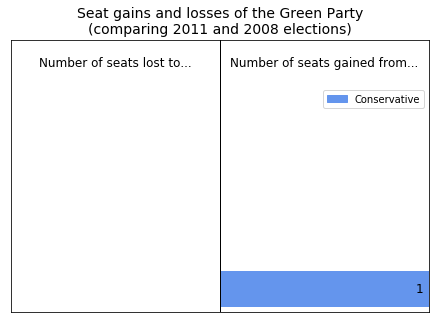

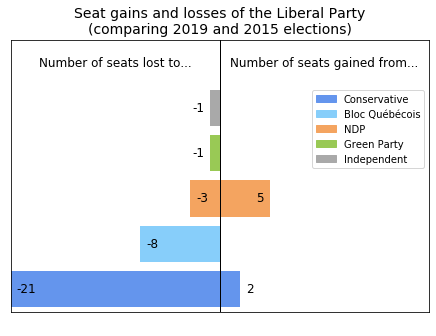

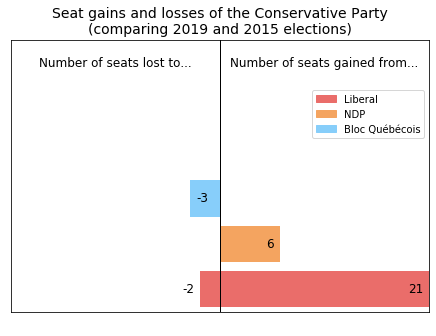

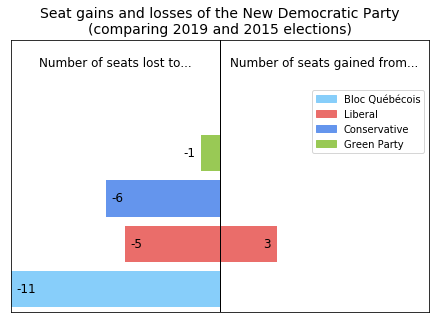

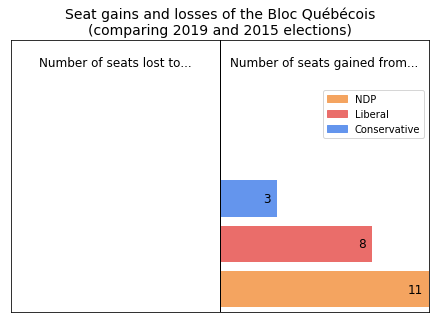

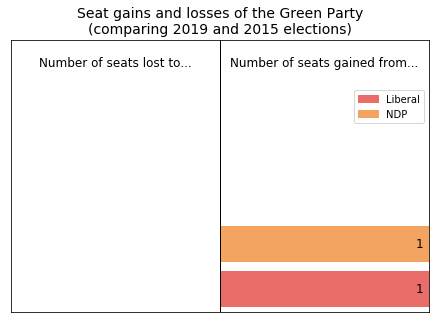

In [37]:
'''
# Bar labeling test - creating test dataset
# Use it as a parameter to plot_chart
party = 'LIB'
data_lst = []
index_lst = []
i = 1
for p in party_lst:
    if p == party:
        continue
    val = len(party_lst) - i
    data_lst += [{ 'Gained from': val, 'Lost to': -val, 'Spread': val * 2 }]
    index_lst += [p]
    i += 1

combined_df = pd.DataFrame(data=data_lst, index=index_lst)
plot_chart(party, this_year, past_year, combined_df)
'''

for (this_year, past_year) in compare_lst:
    # Prepare dataset
    gains_losses_df = prepare_dataset(this_year, past_year)
    
    # Loop through parties and create charts
    for party in party_lst:
        if party == 'OTH': # not a party, some independent candidate
            continue

        combined_df = party_gains_losses(party, gains_losses_df)
        if not len(combined_df): # Green party didn't won any seats up until 2011
            continue

        plot_chart(party, this_year, past_year, combined_df)